# Regression

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import numpy as np

We'll use the same dataset as [before](./1-variables)...

In [2]:
import scanpy as sc

adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata


## Easy things first: Linear regression

In the last tutorial, we learned the main types of variables, and how to connect these to construct a model:
- You either specify them at initialization: `la.Observation(p = ...)`
- Or connect them afterwards: `observation.p = ...`

We can now use these concepts to build a basic model of a transcriptome:

In [3]:
genes = la.Dim(adata.var)
cells = la.Dim(adata.obs)

We first define our overexpression:

In [4]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")

We then define how this overexpression affects our gene expression on average across different cells. To keep things simple, we will first create a linear model that has both a baseline expression $b$ and a slope $a$ for each gene. Because gene expression is only defined for positive numbers, we also add an exponential transformation:

In [5]:
expression = la.links.scalar.Linear(
    overexpression,
    a=True,
    b=True,
    label="expression",
    definition=la.Definition([cells, genes]),
    transforms=[la.transforms.Exp()],
)

Although the latent slope and baseline were created automatically for us by specifying `a = True, b = True`, it's important to remember that we could have easily created these variables ourselves, for example:

```python
slope = la.Latent(
    p = la.distributions.Normal(scale = la.Parameter(1., transforms = [la.transforms.Exp()])),
    definition = [genes]
)
```

While the expression variable models our average expression, what we actually observe is a noisy sample of (UMI) counts. The prototypical way to model this is as a NegativeBinomial2. It has two components, a mean that needs to be positive (hence the exponential transformation from before) and a dispersion that also needs to be positive. This dispersion models the heterogeneity, and as this typically depends on the gene we will model it as a latent variable:

In [6]:
dispersion = la.Latent(
    la.distributions.LogNormal(
        la.Parameter(0.0), la.Parameter(1.0, transforms=[la.transforms.Exp()])
    ),
    definition=la.Definition([genes]),
)

Note the LogNormal prior here: this distribution has a _support_ only positive numbers, and latenta will automatically try to match this support in the variational distribution $q$, in this case by adding an exponention transform:

In [7]:
dispersion.q

q: loc, scale ↦ Normal [gene (•)]

We can now define the distribution that our data will follow:

In [8]:
transcriptome_p = la.distributions.NegativeBinomial2(
    mu=expression, dispersion=dispersion
)

And then we can define our observation:

In [9]:
transcriptome = la.Observation(
    adata.X,
    transcriptome_p,
    definition=[cells, genes],
    label="transcriptome",
)

In [10]:
transcriptome.plot()

Note the many free parameters that form the leaves of our model. These will have to be estimated by the model. But first, why are there so many parameters even for the such a simple linear regression?

Let's remind ourselves what we're actually trying to accomplish. We're trying to create a good model of our observations. There are however many models that will provide a very good fit of the data equally. For example, we could just give the actual count matrix as input to the negative binomial and this trivial model would fit extremely well.

So we don't just want a model. We want a model that can explain our observation well, while being both generalizeable and interpretable. And to accomplish this, we have to limit the flexibility that our model can have. You have already done this in two ways:

- Hard priors are those that completely constrain the model. For example, by specifying a linear function we don't allow any non-linearities. There's simply no way that the model moves beyond these constraints.
- Soft priors are those that only push the latent variables towards more likely values. For example, we want to discourage extreme slopes that are far away from 0, unless the data really provides strong evidence for these extreme slopes

The purpose of these parameters is to balance the wishes of the soft priors to the wishes of the observations. The parameters of the variational distributions $q$ will try to explain the observations while also remaining faithful to the prior distributions $p$. The parameters of $p$ on the other hand will try to accomodate the parameters of $q$ as well as possible, but it cannot do this perfectly as these parameters are shared across all genes. It's this pushing and pulling between priors and variational distributions that prevent overfitting and underfitting of the model. At the same time, through $q$, we get some estimates of the uncertainty of our latent variables for free!

Mathematically speaking, the "wishes of the observations" is called the **likelihood** and noted by $P(x|z)$, where $x$ are the observations and $z$ the latent variables. The "wishes of the prior" on the other hand is called the **prior probability** and noted by $P(z)$.

To infer an optimal value for these parameters, we have to find a solution that best balances the needs of the prior distribution with those of the observations. And one of the fastest ways to do that is to use gradient descent, which starts from an initial value and then tries to move these initial values slowly but surely into better values. These tasks are fullfilled by a loss function (`ELBO`), an optimizer (`Adam`), and an overarching training class (`SVI`):

In [11]:
inference = la.infer.svi.SVI(
    transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)

We can now train for a couple of iterations or until the loss function has reached convergence:

  0%|                                                                                                         …

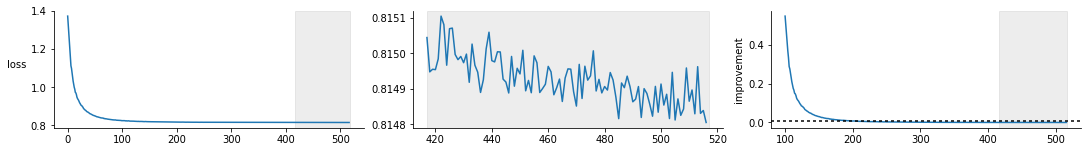

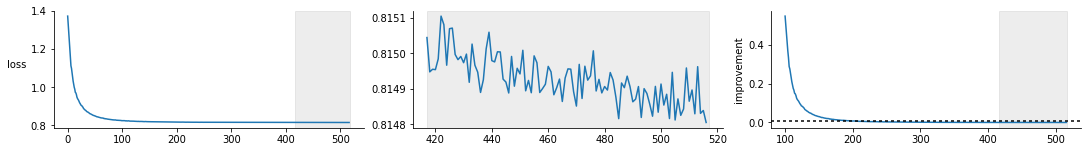

In [12]:
trace = trainer.train(10000)
trace.plot()

You can check that our values have changed:

In [13]:
transcriptome.p.mu.a.q.loc.run_local()
transcriptome.p.mu.a.q.loc.value_pd.head()

gene
ENSMUSG00000000031    1.091546
ENSMUSG00000000058   -0.150200
ENSMUSG00000000078   -0.108866
ENSMUSG00000000184   -0.039271
ENSMUSG00000000202    0.976036
dtype: float32

Our inference algorithm did not fullfill all 10000 iterations, but has permaturely stopped as it has detected _convergence_. Do note that this converge is not always perfect, and we will see later that there are some circumstances where further training may be advisable.

## Interpreting a regression model

For interpretation of the model, we can then use 3 main types of posteriors:

### Observed posteriors

Because we are working with a probabilistic model, every time we run through the model our results will change. For example, each time we sample from variational distribution of the slope $q$ the output will be different, which will affect any downstream variables even if they are themselves deterministic. To interpret the results, we thus have to sample multiple times from the model, using a {class}`~la.posterior.Observed` posterior:

In [14]:
transcriptome_observed = la.posterior.Observed(
    transcriptome, retain_samples={expression.a}
)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

`.samples` is a dictionary containing the samples of each variable that was upstream of the transcriptome (if they were provided in the `retain_samples` list). We can access each variable either by providing the variable itself:

In [15]:
transcriptome_observed.samples[expression.a]

<xarray.DataArray 'slope' (sample: 5, gene: 2047)>
array([[ 0.9925853 , -0.14894937, -0.14770365, ..., -0.29892638,
        -0.35501516,  0.07712387],
       [ 1.3203809 , -0.15689895, -0.127355  , ..., -0.16231406,
        -0.46768367,  0.08817019],
       [ 1.2109838 , -0.18069917, -0.05070984, ..., -0.25209665,
        -0.08256148,  0.04935593],
       [ 1.1302456 , -0.05322082, -0.10328682, ..., -0.23830202,
        -0.21221255, -0.01160041],
       [ 1.2684073 , -0.17144796, -0.16936901, ..., -0.17708993,
        -0.17326891,  0.15206106]], dtype=float32)
Coordinates:
  * gene     (gene) <U18 'ENSMUSG00000000031' ... 'ENSMUSG00000118365'
Dimensions without coordinates: sample

:::{note}
Latenta makes extensive use of the [xarray](https://xarray.pydata.org/en/stable/) library for annotated data in more than 2 dimensions. All samples are always stored as {py:class}`xarray.DataArray` objects. Important functions to know are:
- {py:meth}`~xarray.DataArray.sel` to select a subset of the data
- {py:meth}`~xarray.DataArray.to_pandas` to convert a 2D or 1D array to a pandas DataFrame or Series
- {py:attr}`~xarray.DataArray.dims` to get the dimensions of the data
- {py:attr}`~xarray.DataArray.values` to get the values as a numpy array
- {py:meth}`~xarray.DataArray.mean` to get the mean across a dimension
- {py:class}`xarray.DataArray` to construct a new DataArray
:::

For example, we can get and rank by mean slope as follows:

In [16]:
mean_slopes = (
    transcriptome_observed.samples[expression.a]
    .mean("sample")
    .to_pandas()
    .sort_values()
)

scores = mean_slopes.rename("slope").to_frame()
scores["symbol"] = adata.var["symbol"][scores.index]
scores

,slope,symbol
gene,,
ENSMUSG00000066058,-0.854257,Cldn19
ENSMUSG00000040569,-0.765452,Slc26a7
ENSMUSG00000103047,-0.704675,Gm37310
ENSMUSG00000017453,-0.648606,Pipox
ENSMUSG00000086331,-0.645103,Gm16310
...,...,...
ENSMUSG00000051747,1.423381,Ttn
ENSMUSG00000009214,1.426402,Mymk
ENSMUSG00000099906,1.426654,Gm28653


### Causal posteriors

To know how one variable influences another, we use a causal posterior. In essense, this posterior will set a variable of your choice to particular values, and then see how an output variables (and any intermediates) are affected. Latenta contains many different types of causal posteriors, which mainly differ in their visualization capabilities. Here we will use a {class}`~latenta.posterior.scalar.ScalarVectorCausal` posterior, because we are studying how a **scalar** variable (one value for each cell) impacts a **vector** (gene expression for each cell):

In [17]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome
)
overexpression_causal.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

This posterior also contains samples, but now for some _pseudocells_ with each a distinct value for the `overexpression` variable:

In [18]:
overexpression_causal.samples[overexpression].mean("sample")

<xarray.DataArray 'overexpression' (cell: 100)>
array([0.        , 0.09165025, 0.1833005 , 0.27495077, 0.366601  ,
       0.45825118, 0.54990155, 0.6415518 , 0.733202  , 0.82485235,
       0.91650236, 1.0081528 , 1.0998031 , 1.1914531 , 1.2831036 ,
       1.3747538 , 1.466404  , 1.5580541 , 1.6497047 , 1.7413547 ,
       1.8330047 , 1.9246553 , 2.0163057 , 2.1079557 , 2.1996062 ,
       2.2912562 , 2.3829062 , 2.4745567 , 2.5662074 , 2.6578574 ,
       2.7495077 , 2.841158  , 2.932808  , 3.0244582 , 3.1161082 ,
       3.2077584 , 3.2994094 , 3.3910594 , 3.4827094 , 3.5743594 ,
       3.6660094 , 3.7576604 , 3.8493104 , 3.9409604 , 4.0326114 ,
       4.1242604 , 4.2159114 , 4.3075624 , 4.3992124 , 4.490863  ,
       4.5825124 , 4.674163  , 4.7658124 , 4.8574634 , 4.9491134 ,
       5.040764  , 5.1324143 , 5.2240644 , 5.315715  , 5.4073644 ,
       5.4990153 , 5.5906644 , 5.6823153 , 5.7739654 , 5.865616  ,
       5.957267  , 6.0489163 , 6.1405673 , 6.2322164 , 6.3238673 ,
       6.415517  , 6.507168  , 6.598819  , 6.690469  , 6.782119  ,
       6.873769  , 6.965419  , 7.057069  , 7.14872   , 7.2403708 ,
       7.332019  , 7.4236703 , 7.515321  , 7.606971  , 7.698621  ,
       7.790271  , 7.881921  , 7.973572  , 8.065223  , 8.156874  ,
       8.248522  , 8.340173  , 8.431823  , 8.523474  , 8.615125  ,
       8.706773  , 8.798425  , 8.890075  , 8.981726  , 9.073374  ],
      dtype=float32)
Coordinates:
  * cell     (cell) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99

Depending on the type of causal posterior, you can plot the outcome. The {class}`~latenta.posterior.scalar.ScalarVectorCausal` can for example plot each individual _feature_ across all cells (in this case gene):

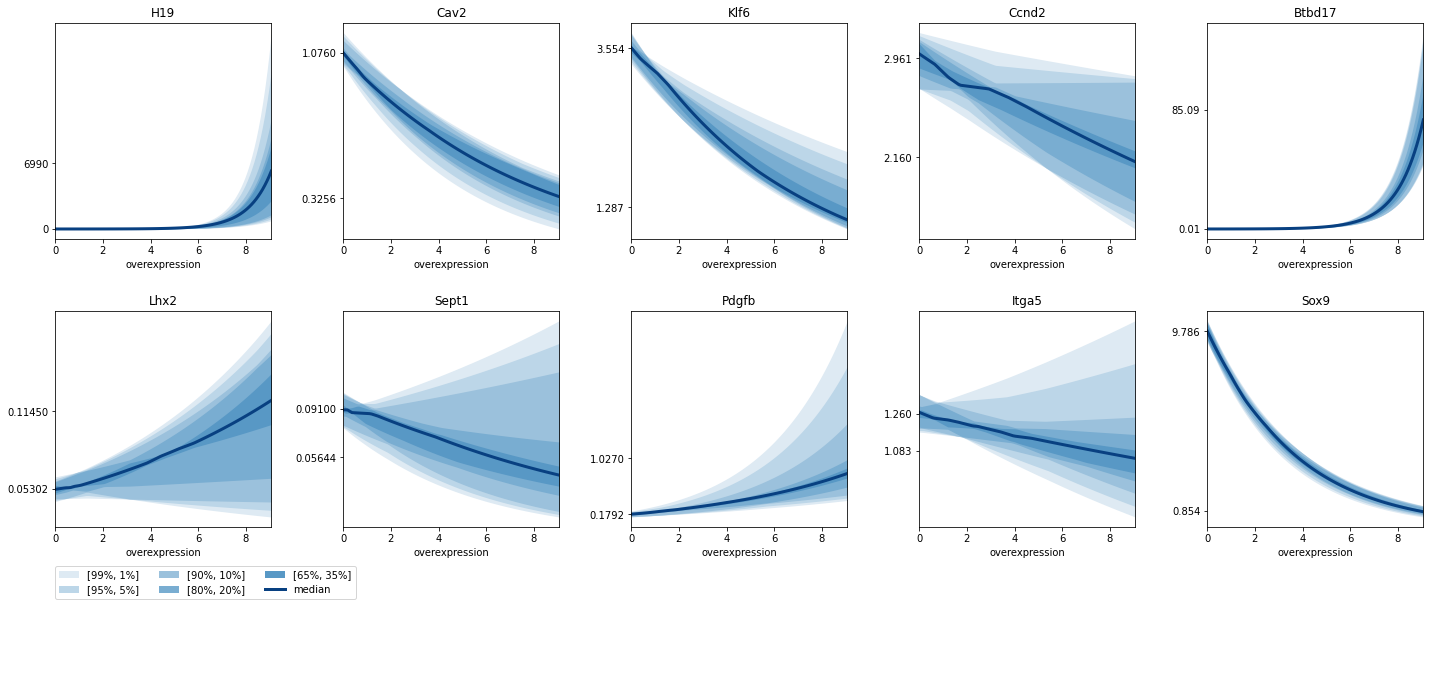

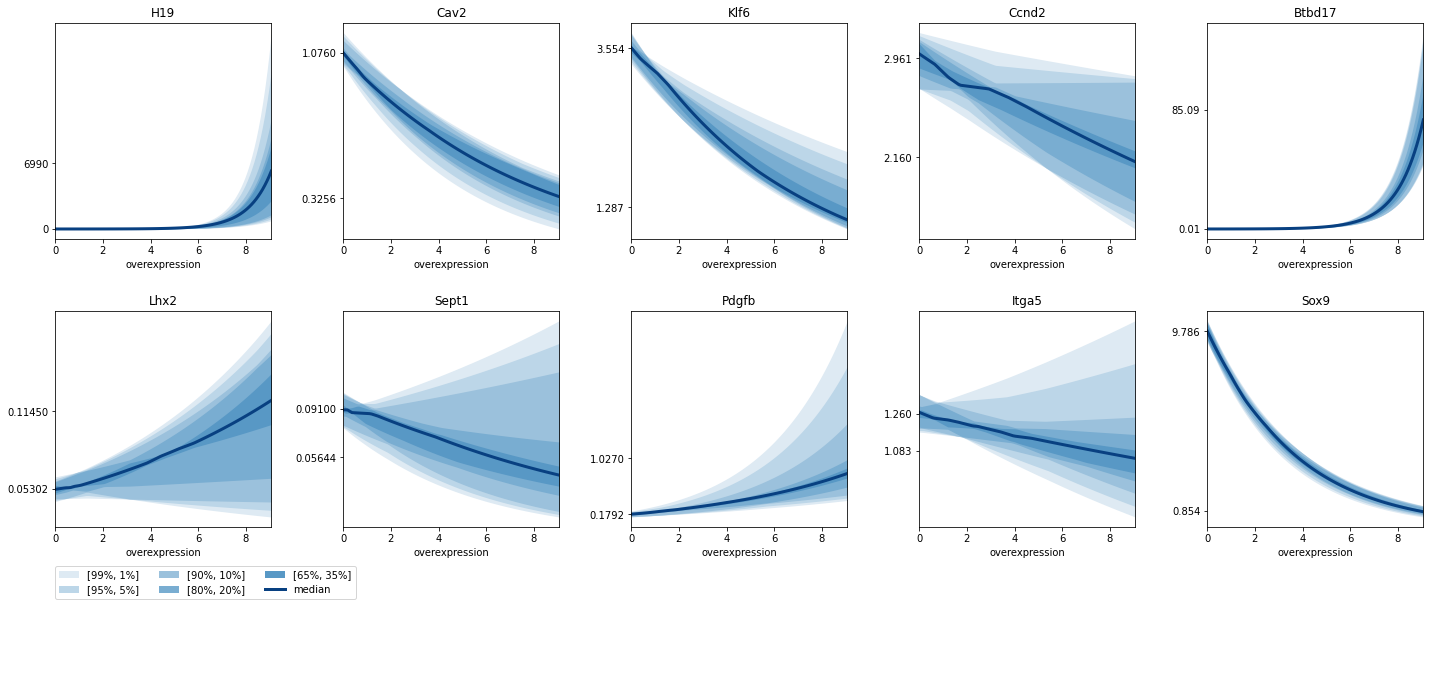

In [19]:
overexpression_causal.plot_features()

This plot shows both the _median_ value of each gene across different doses of a transcription factors, together with several _credible intervals_ as shades areas. The credible interval shows, within the constraints of soft and hard priors, where the actual average value of the gene expression will lie.

::::{margin}
:::{seealso}
https://en.wikipedia.org/wiki/Credible_interval
:::
::::

In [20]:
from myst_nb import glue

glue(
    "conditional",
    la.utils.latex.convert_mathtex_to_latex(
        f"$P({transcriptome.p.mu.symbol}|{overexpression.symbol} = ...)$"
    ),
)

'$P(\\text{ expression }|\\text{ overexpression } = ...)$'

Mathematically, this plot represents the conditional posterior:

$$P(\mu|\text{overexpression} = ...)$$

A causal posterior can also provide a score dataframe that will rank each _feature_ (gene). In this case, this also includes columns for the maximal fold change (`fc`), absolute change (`ab`) and peak input value (`peak`).

In [21]:
overexpression_causal.scores

,label,fc,ac,peak
gene,,,,
ENSMUSG00000000031,H19,14378.401367,6989.836426,9.073374
ENSMUSG00000000058,Cav2,3.305642,0.750747,0.000000
ENSMUSG00000000078,Klf6,2.762093,2.267117,0.000000
ENSMUSG00000000184,Ccnd2,1.370737,0.800864,0.000000
ENSMUSG00000000202,Btbd17,6358.073242,85.077179,9.073374
...,...,...,...,...
ENSMUSG00000117278,AC166110.4,9.187534,0.336617,9.073374
ENSMUSG00000117515,AC121783.1,1.910185,0.067872,9.073374
ENSMUSG00000117710,AC124502.1,2.668684,0.020335,0.000000


### Perturbed posteriors

To understand whether a variable has an important impact on the downstream variable, we use perturbed posteriors. These posteriors work in a very similar way as the observed posterior, but rather than using the actual value of the variable, it uses a perturbed version. The type of perturbation varies depending on which question we want to address, and can include random shuffling, random sampling from the prior, or conditionalizing on a fixed value.

While you can independently construct a perturbed posterior, you will typically create it indirectly through a causal posterior. For example, we can do random sampling from the prior using:

In [22]:
overexpression_causal.sample_random()

  0%|          | 0/10 [00:00<?, ?it/s]

To check the impact of a variable on our observation, we calculate a (log-)likelihood ratio: how much more likely is the observed expression before and after we perturbed our upstream variable?

In [23]:
overexpression_causal.likelihood_ratio

<xarray.DataArray (gene: 2047)>
array([424.40283  ,  57.015503 ,  97.76575  , ...,   6.3622513,
         8.655907 ,   8.196838 ], dtype=float32)
Coordinates:
  * gene     (gene) <U18 'ENSMUSG00000000031' ... 'ENSMUSG00000118365'

Mathematically, these values represents the ratio between posteriors probabilities:

$$\frac{P(\mu|\text{overexpression})}{P(\mu|\text{overexpression}_\text{shuffled})}$$

These likelihood ratios were also automatically added to our scores table:

In [24]:
overexpression_causal.scores.head()

,label,fc,ac,lr,peak
gene,,,,,
ENSMUSG00000026981,Il1rn,69.777824,7.542462,1806.649170,0.000000
ENSMUSG00000089774,Slc5a3,25.457094,6.122306,1701.650146,0.000000
ENSMUSG00000047793,Sned1,26.692478,4.062956,1552.186157,0.000000
ENSMUSG00000037062,Sh3glb1,40.820656,137.344589,1231.019287,9.073374
ENSMUSG00000005360,Slc1a3,10.467866,17.248690,1207.192871,0.000000


:::{note}
These likelihood ratios are mainly useful to understand the impact of a variable on an outcome *within a model*. In the model selection tutorial, we will introduce a better measure to quantify whether a variable **significantly** affects an outcome, by comparing it to other simpler or more complex models.
:::

## Using _lacell_ to make model creation easier

Specific modalities in single-cell data typically require a similar way of normalization and statistical modelling, and we have collected such prototypical models into the `lacell` package. For example, we can directly construct a model for transcriptomics from an AnnData object as follows:

In [27]:
import lacell as lac

transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
transcriptome.plot()

Note that this model is a bit more complex that the model we created before. In particular, it contains a library size normalization that will normalize the counts of each gene with a cell to the cell's total counts. However, the main ideas remain the same:

- We model the counts as a negative binomial distributions, with a dispersion $\theta$ and mean $\mu$.
- The mean $\mu$ is modelled as a linear combination of the relative expression in a cell $\rho$, and its library size $\mathit{lib}$. The library size is set to the empirical library size (i.e. simply the sum of the counts in each cell).
- The $\rho$ itself is a linear combination of the average expression of each gene in the cell $\nu$, modelled as a latent variable, and the log-fold change $\delta$.
- The log-fold change $\delta$ is a modular variable.
- When modelling cellular processes, we typically add things to the log-fold change $\delta$. However, you can also adapt any other variables, such as the library size or dispersion, if this makes sense from a biological or technical perspective.

:::{seealso}
[Why don't we just provide normalized data to latenta?](why-not-just-provide-normalized-data)
:::

Once models reach a certain complexity, it becomes easier to get a variable using the {meth}`~latenta.variables.Composed.find` function, which will recursively look for an object with the given label or symbol:

In [28]:
foldchange = transcriptome.find("foldchange")

Let's add the overexpression to the fold change:

In [29]:
foldchange.overexpression = la.links.scalar.Linear(
    overexpression, a=True, label="expression", definition=foldchange.value_definition
)

Note that we do not transform this variable, nor do we add a baseline (or intercept) to this function as this is all handled downstream by the $\rho$ function:

In [30]:
transcriptome.plot()

## More complex regression problems

### Non-linear

To consider non-linear relationships, we can use any of the non-linear link functions implemented in latenta:

In [31]:
import pandas as pd
import IPython.display

links = [la.links.scalar.Logistic, la.links.scalar.Spline, la.links.scalar.Sigmoid]

link_table = []
for link in links:
    link_table.append(
        {
            "name": link.__name__,
            "reference": "`" + link.__module__ + "." + link.__name__ + "`",
            "description": link.__doc__.strip().split("\n")[0],
        }
    )
link_table = pd.DataFrame(link_table)
IPython.display.HTML(link_table.to_html())

,name,reference,description
0,Logistic,`latenta.links.scalar.sigmoid.Logistic`,Logistic function:
1,Spline,`latenta.links.scalar.spline.Spline`,"Smooth, one dimensional, spline."
2,Sigmoid,`latenta.links.scalar.sigmoid.Sigmoid`,Standard sigmoid kinetics:


We'll illustrate {class}`latenta.links.scalar.spline.Spline`.

In [32]:
foldchange = transcriptome.find("foldchange")

In [33]:
foldchange.overexpression = la.links.scalar.Spline(
    overexpression,
    label="expression",
    definition=foldchange.value_definition,
    transforms=[la.transforms.Exp()],
)

In [34]:
foldchange.plot()

In [35]:
inference = la.infer.svi.SVI(
    transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)
trace.plot()

In [37]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome
)
overexpression_causal.observed.sample()
overexpression_causal.sample(30)
overexpression_causal.sample_empirical()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

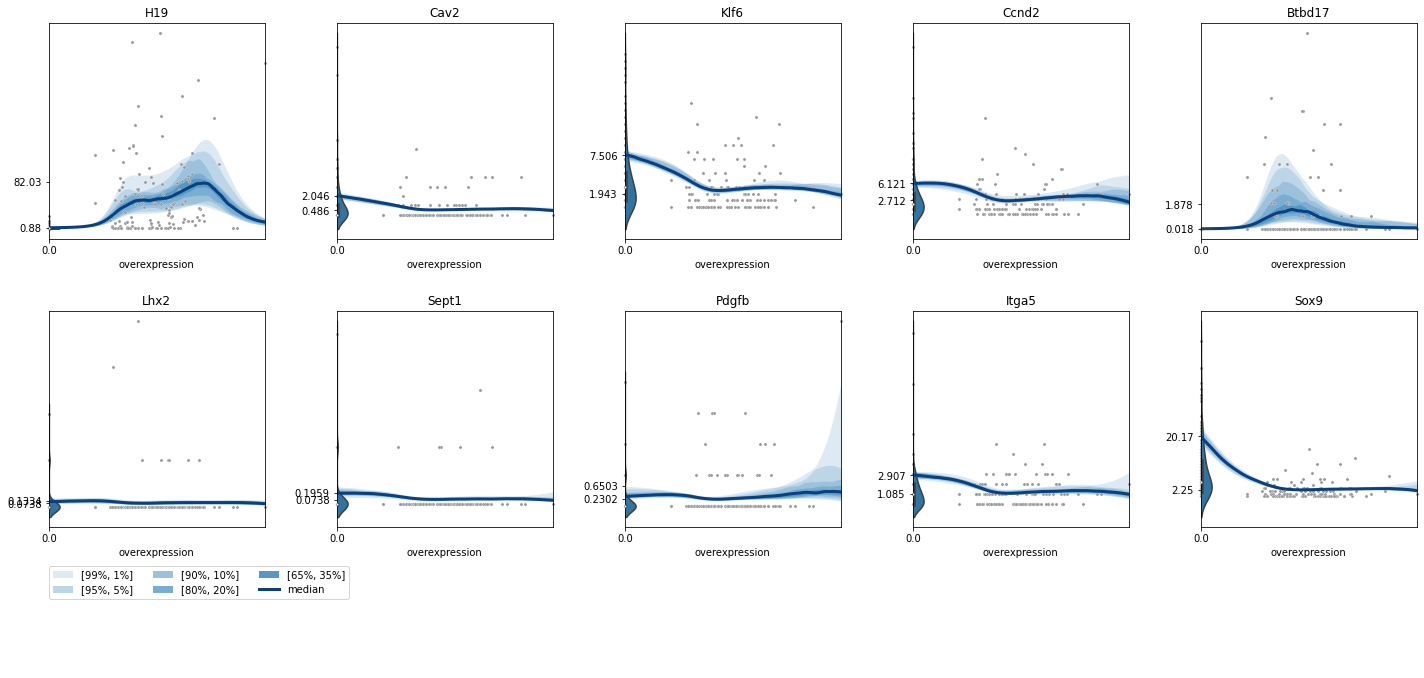

In [67]:
overexpression_causal.plot_features();

### Multiple regression

Let's say we wanted to find out how both the overexpression and the cell cycle affect the transcriptome. A naive way of doing that would be to use the canonical S and G2M scores as input for a linear regression:

In [57]:
cellcycle_genes = lac.cell.cellcycle.get_cellcycle_genes("mm")
sc.tl.score_genes_cell_cycle(
    adata,
    cellcycle_genes.query("phase == 'S'")["gene"],
    cellcycle_genes.query("phase == 'G2/M'")["gene"],
)

In [62]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
foldchange = transcriptome.find("foldchange")

In [63]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")
foldchange.overexpression = la.links.scalar.Linear(overexpression, a=True, definition=foldchange.value_definition)

In [65]:
S = la.Fixed(adata.obs["S_score"])
foldchange.S = la.links.scalar.Linear(S, a=True, definition=foldchange.value_definition)

G2M = la.Fixed(adata.obs["G2M_score"])
foldchange.G2M = la.links.scalar.Linear(G2M, a=True, definition=foldchange.value_definition)

In [66]:
foldchange.plot()

:::{warning}
Given that the cell cycle is a circular process, this way of detecting modelling the cell cycle has some obvious flaws. This is merely included here for illustration purposes.
:::

  0%|                                                                                                         …

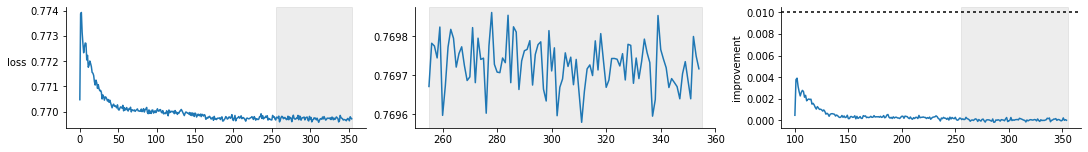

In [69]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

In [70]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome
)
overexpression_causal.observed.sample()
overexpression_causal.sample(30)
overexpression_causal.sample_empirical()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

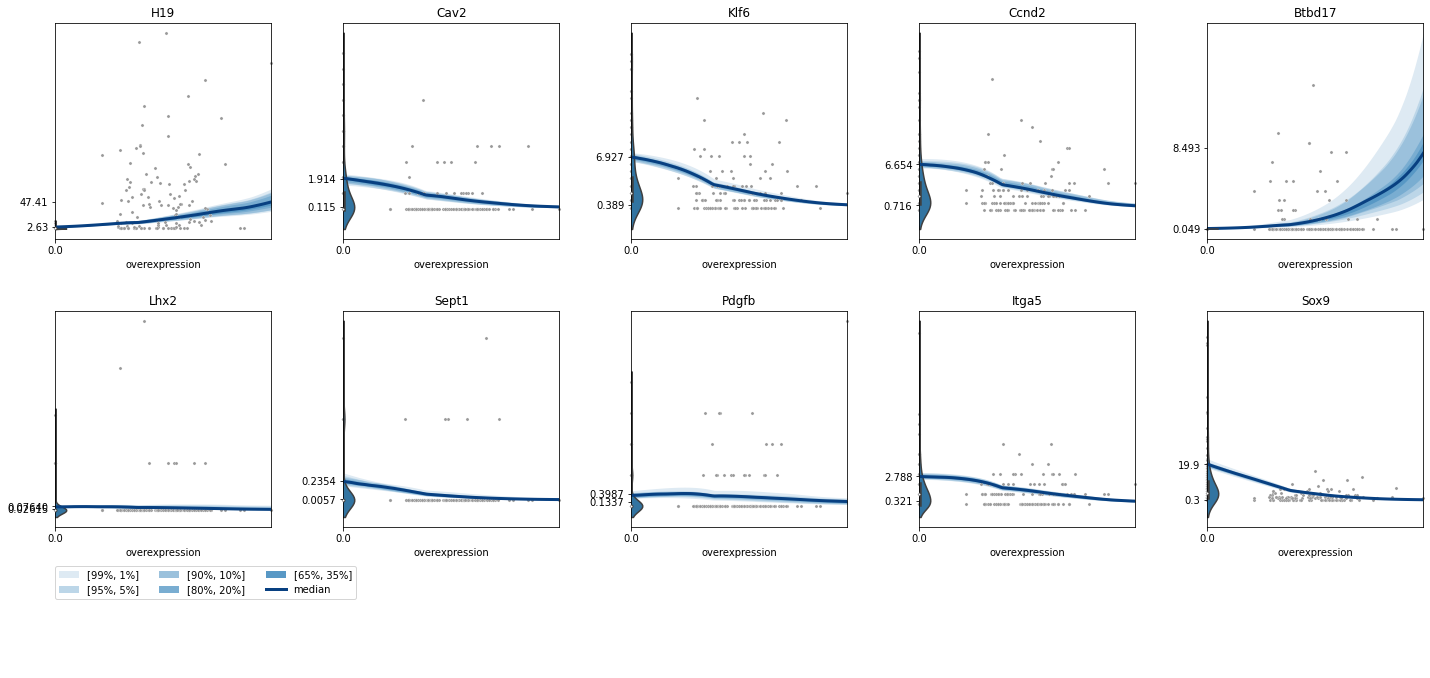

In [71]:
overexpression_causal.plot_features();